In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as spo
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import ensemble

In [2]:
# ---

data = pd.read_csv("C:\\Users\\HOME\\Desktop\\EURUSD_M5_V2.csv", sep = "\t")

# ---

dt = data['<DATE>'] + " " + data['<TIME>']
dt_0 = datetime.datetime.strptime(dt[0], "%Y.%m.%d %H:%M:%S")
time = np.array([(datetime.datetime.strptime(c, "%Y.%m.%d %H:%M:%S") - dt_0).total_seconds() for c in dt])
data = pd.concat((pd.Series(time, name = '<TIME>'), data['<OPEN>'], data['<HIGH>'], data['<LOW>'], data['<CLOSE>']), axis = 1)

diff_time = data['<TIME>'][1]

# data = pd.concat([data['<TIME>'], data.drop('<TIME>', axis = 1) * 100], axis = 1)

# ---

section_num = 10
last_ind = section_num - 1
num_rows = data.shape[0] - section_num

# ---

ohlc_columns = []
for c in range(section_num):
    ohlc_columns.append(f'OPEN{c}')
    ohlc_columns.append(f'HIGH{c}')
    ohlc_columns.append(f'LOW{c}')
    ohlc_columns.append(f'CLOSE{c}')
ohlc_data = pd.DataFrame(columns = ohlc_columns)

oc_columns = []
for c in range(section_num):
    oc_columns.append(f'OPEN{c}')
    oc_columns.append(f'CLOSE{c}')
oc_data = pd.DataFrame(columns = oc_columns)

open_columns = [f'OPEN{c}' for c in range(section_num)]
open_data = pd.DataFrame(columns = open_columns)

# ---

for c in range(section_num):
    ohlc_data[f'OPEN{c}'] = data['<OPEN>'][c:num_rows + c].reset_index(drop = True)
    ohlc_data[f'HIGH{c}'] = data['<HIGH>'][c:num_rows + c].reset_index(drop = True)
    ohlc_data[f'LOW{c}'] = data['<LOW>'][c:num_rows + c].reset_index(drop = True)
    ohlc_data[f'CLOSE{c}'] = data['<CLOSE>'][c:num_rows + c].reset_index(drop = True)
    # 
    oc_data[f'OPEN{c}'] = ohlc_data[f'OPEN{c}']
    oc_data[f'CLOSE{c}'] = ohlc_data[f'CLOSE{c}']
    #
    open_data[f'OPEN{c}'] = ohlc_data[f'OPEN{c}']


In [101]:
difference = np.abs(data['<OPEN>'][0:data.shape[0] - 1].reset_index(drop = True) - data['<OPEN>'][1:data.shape[0]].reset_index(drop = True))
mean_difference = difference.mean()
mean_difference

0.0002689178502442906

--- Аппроксимируем данные ---

In [3]:
def my_fun1(x, a, b, c):
    return a / (x + 1) + b * x + c

def my_fun_arr1(x, p):
    return p[0] / (x + 1) + p[1] * x + p[2]

def my_fun2(x, a, b):
    return a * x + b

def my_fun_arr2(x, p):
    return p[0] * x + p[1]

# Используем открытые и закрытые
def oc_xy_val(y_row_index):
    x_val = []
    for c in range(section_num):
        x_val.append(c * diff_time)
        x_val.append((c + 1) * diff_time - 1)
    x_val = x_val / diff_time
    y_val = np.array(oc_data.iloc[y_row_index])

    # print(round(open_data['CLOSE' + f'{last_ind}'][y_row_index] - open_data['OPEN' + f'{last_ind}'][y_row_index], 5))
    return x_val, y_val

# Используем открытые
def open_xy_val(y_row_index):
    x_val = [c * diff_time for c in range(section_num)]
    x_val = x_val / diff_time
    y_val = np.array(open_data.iloc[y_row_index])

    # print(round(open_data['OPEN' + f'{last_ind}'][y_row_index] - open_data['OPEN' + f'{last_ind - 1}'][y_row_index], 5))
    return x_val, y_val

# ---
def plot_trajectory(my_fun, my_fun_arr, y_row_index):
    x_val, y_val = open_xy_val(y_row_index)
    spopt, spcov = spo.curve_fit(my_fun, x_val[0:-1], y_val[0:-1])
    popt, pcov = spo.curve_fit(my_fun, x_val, y_val)
    x_ls = np.linspace(x_val[0], x_val[-1], 100)

    plt.plot(x_val, y_val, 'bo')
    plt.plot(x_ls, my_fun_arr(x_ls, popt), label = 'small_val')
    plt.plot(x_ls, my_fun_arr(x_ls, spopt), label = 'val')
    plt.grid(True)
    plt.legend()

def get_error(my_fun, my_fun_arr, x_val, y_val):
    spopt, spcov = spo.curve_fit(my_fun, x_val[0:-1], y_val[0:-1])
    popt, pcov = spo.curve_fit(my_fun, x_val, y_val)

    err = my_fun_arr(x_val, popt) - y_val
    serr = my_fun_arr(x_val, spopt) - y_val
    return serr, err

def get_opt(my_fun, my_fun_arr, x_val, y_val):
    spopt, spcov = spo.curve_fit(my_fun, x_val[0:-1], y_val[0:-1])
    popt, pcov = spo.curve_fit(my_fun, x_val, y_val)
    return spopt, popt

def plot_error(my_fun, my_fun_arr, y_row_index):
    x_val, y_val = open_xy_val(y_row_index)
    serr, err = get_error(my_fun, my_fun_arr, x_val, y_val)
    
    plt.plot(x_val, serr, label = 'serr')
    plt.plot(x_val, err, label = 'err')
    plt.plot(x_val, serr - err, label = 'serr - err')
    plt.grid(True)
    plt.legend()
    return serr, err

def get_diff(my_fun_arr, x_val, y_val, opt):
    return my_fun_arr(x_val, opt) - y_val

def double_plot_error(my_fun, my_fun_arr, y_row_index):
    x_val, y_val = open_xy_val(y_row_index)
    spopt0, popt0 = get_opt(my_fun, my_fun_arr, x_val, y_val)
    y0 = y_val[0]

    x_val, y_val = open_xy_val(y_row_index + 1)
    spopt1, popt1 = get_opt(my_fun, my_fun_arr, x_val, y_val)
    
    x_val, y_val = np.concatenate([x_val, np.array([section_num])]), np.concatenate([np.array([y0]), y_val])
    serr0 = my_fun_arr(x_val, spopt0) - y_val
    err0 = my_fun_arr(x_val, popt0) - y_val
    serr1 = my_fun_arr(x_val, spopt1) - y_val
    err1 = my_fun_arr(x_val, popt1) - y_val
    
    plt.plot(x_val, serr0, label = 'serr0')
    plt.plot(x_val, err0, label = 'err0')
    plt.plot(x_val, serr1, label = 'serr1')
    plt.plot(x_val, err1, label = 'err1')

    '''plt.plot(x_val, serr0, label = 'serr0')
    plt.plot(x_val, err0, label = 'err0')
    plt.plot(x_val + 1, serr1, label = 'serr1')
    plt.plot(x_val + 1, err1, label = 'err1')'''
    plt.grid(True)
    plt.legend()
    return serr0, err0, spopt0, popt0, serr1, err1, spopt1, popt1

def diff_fun_plot_error(y_row_index):
    x_val, y_val = open_xy_val(y_row_index)
    f1_serr, f1_err = get_error(my_fun1, my_fun_arr1, x_val, y_val)
    f2_serr, f2_err = get_error(my_fun2, my_fun_arr2, x_val, y_val)

    plt.plot(x_val, f1_serr, label = 'f1_serr')
    # plt.plot(x_val, f1_err, label = 'f1_err')
    # plt.plot(x_val, f1_serr - f1_err, label = 'f1_serr - f1_err')
    plt.plot(x_val, f2_serr, label = 'f2_serr')
    # plt.plot(x_val, f2_err, label = 'f2_err')
    # plt.plot(x_val, f2_serr - f2_err, label = 'f2_serr - f2_err')
    plt.grid(True)
    plt.legend()

my_fun, my_fun_arr = my_fun2, my_fun_arr2

In [190]:
def bugaga(y_row_index):
    x_val, y_val = open_xy_val(y_row_index)
    serr0, err0 = get_error(my_fun, my_fun_arr, x_val, y_val)
    sopt0, scov0 = spo.curve_fit(my_fun, x_val[1:-1], serr0[1:-1])
    see0 = my_fun_arr(x_val, sopt0)

    x_val, y_val = open_xy_val(y_row_index + 1)
    serr1, err1 = get_error(my_fun, my_fun_arr, x_val, y_val)
    sopt1, scov1 = spo.curve_fit(my_fun, x_val[1:-1], serr1[1:-1])
    see1 = my_fun_arr(x_val, sopt1)
    
    plt.plot(x_val, serr1, label = 'serr')
    plt.plot(x_val, see1, label = 'see')
    plt.grid(True)
    plt.legend()
    return serr0, see0, serr1, see1

9.928571338698364e-05 0.0003453333311522755


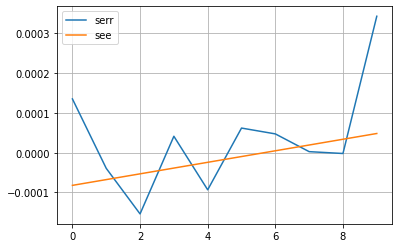

In [201]:
serr0, see0, serr1, see1 = bugaga(2)
print(see1[-1] - see0[-1], serr1[last_ind] - serr1[last_ind-1])

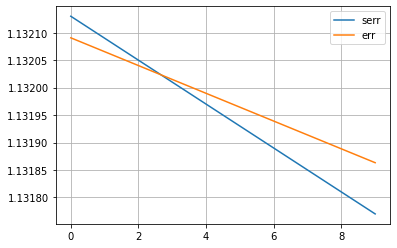

In [7]:
x_val, y_val = open_xy_val(5)

li = x_val.shape[0] - 1
slopt, slcov = spo.curve_fit(my_fun, x_val[0:li - 1], y_val[0:li - 1])
sopt, scov = spo.curve_fit(my_fun, x_val[0:li], y_val[0:li])
sfopt, sfcov = spo.curve_fit(my_fun, x_val[1:li], y_val[1:li])
opt, cov = spo.curve_fit(my_fun, x_val, y_val)

eopt, ecov = spo.curve_fit(my_fun, x_val[1:], y_val[1:])
see = my_fun_arr(x_val, eopt)

slerr = my_fun_arr(x_val, slopt)
serr = my_fun_arr(x_val, sopt)
sferr = my_fun_arr(x_val, sfopt)
err = my_fun_arr(x_val, opt)

plt.plot(x_val, serr, label = 'serr')
#plt.plot(x, err, label = 'err')
#plt.plot(x, slerr, label = 'slerr')
#plt.plot(x, sferr, label = 'sferr')
plt.plot(x_val, err, label = 'err')
plt.grid(True)
plt.legend()

In [ ]:
serr, err = plot_error(my_fun, my_fun_arr, 0)

-1.0333333333445438e-05 -2.0424244605354858e-05
-5.250000218137707e-05 -5.157575975700546e-05


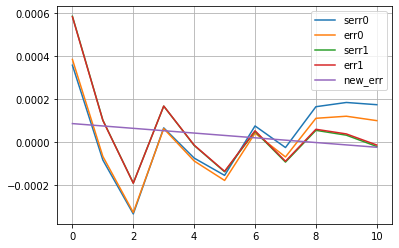

In [65]:
serr0, err0, spopt0, popt0, serr1, err1, spopt1, popt1 = double_plot_error(my_fun, my_fun_arr, 0)

li = last_ind + 1
new_err, move = (serr1 + err1) / 2, 0
x_val = np.arange(move, new_err.shape[0] + move)
plt.plot(x_val, my_fun_arr(x_val, (spopt0 + spopt1) / 2 - popt0), label = 'new_err')
plt.legend()
print(serr0[li] - serr0[li-1], err0[li] - err0[li-1])
print(serr1[li] - serr1[li-1], err1[li] - err1[li-1])

[-1.07024109e-04 -1.78879310e-05  9.35769465e-05]
[-4.93939394e-06  1.31717172e-05]


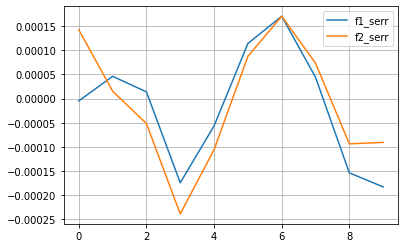

In [72]:
diff_fun_plot_error(19)

In [141]:
serr_last = []
diff_end = []
for i in range(num_rows):
    x_val, y_val = open_xy_val(i)
    serr, err = get_error(my_fun, my_fun_arr, x_val, y_val)
    diff_end.append(abs(serr[-1] - err[-1]))
    serr_last.append(abs(serr[-1]))
diff_end, serr_last = np.array(diff_end), np.array(serr_last)
mean = diff_end.mean()
std = diff_end.std()
print(f'mean = {mean}, std = {std}')

C:\Users\HOME\AppData\Local\Programs\Python\Python310\Lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


mean = 0.00013103646627781994, std = 0.0001440853053676201


In [10]:
less_min = np.array([i for i in range(diff_end.shape[0]) if diff_end[i] < 10**(-5)])
eq_val = np.array([i for i in range(serr_last.shape[0]) if serr_last[i] < 10**(-5)])
print(less_min.shape[0], eq_val.shape[0])

2490 1059


In [76]:
y_row_index = 16
x_val, y_val = open_xy_val(y_row_index)
sserr, serr, err = get_error(my_fun, my_fun_arr, x_val, y_val)
print(abs(serr[-1] - err[-1]))

spopt, spcov = spo.curve_fit(my_fun, x_val[0:-1], y_val[0:-1])
y_spopt = my_fun_arr(x_val, spopt)

print(y_spopt.shape[0], y_val.shape[0])

mult = 3
opt_diff = []
for h in np.arange(-mult * 10**(-5), mult * 10**(-5), 10**(-5)):
    y_val[-1] = y_spopt[-1] + h
    popt, pcov = spo.curve_fit(my_fun, x_val, y_val)
    y_opt = my_fun_arr(x_val, popt)
    opt_diff.append(abs(y_opt[-1] - y_spopt[-1]))
opt_diff = np.array(opt_diff)
print(opt_diff.max())

6.237373735729079e-06
10 10
1.036364304818349e-05


In [266]:
err_columns = [f'ERR_OPEN{c}' for c in range(section_num)]

table = []
for i in range(open_data.shape[0]):
    x_val, y_val = open_xy_val(i)
    serr, err = get_error(my_fun, my_fun_arr, x_val, y_val)
    table.append(serr)

err_data = pd.DataFrame(data = table, columns = err_columns)

C:\Users\HOME\AppData\Local\Programs\Python\Python310\Lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [267]:
x = err_data.drop(f'ERR_OPEN{last_ind}', axis = 1)
y = np.sign(err_data[f'ERR_OPEN{last_ind}'] - err_data[f'ERR_OPEN{last_ind - 1}'])

'''y = []
for i in range(err_data.shape[0]):
    if abs(err_data[f'ERR_OPEN{last_ind}'][i]) < 10**(-5):
        y.append(1)
    else:
        y.append(0)'''
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

In [ ]:
# ada = ensemble.AdaBoostClassifier(n_estimators = 1000)
# ada = ensemble.RandomForestClassifier(n_estimators = 1000)
# ada = ensemble.GradientBoostingClassifier()
# ada = ensemble.ExtraTreesClassifier(n_estimators = 1000)

In [268]:
ada = ensemble.RandomForestClassifier(n_estimators = 1000)
ada.fit(x_train, y_train)

err_train = 1 - ada.score(x_train, y_train)
err_test = 1 - ada.score(x_test, y_test)
print(err_train, err_test)

0.0 0.4869533593963088


In [ ]:
y_cur = y_test
y_predict = ada.predict(x_test)
pr00, pr01, pr10, pr11 = 0, 0, 0, 0
for i in range(y_predict.shape[0]):
    if y_predict[i] == 0:
        if y_cur[i] == 0:
            pr00 = pr00 + 1
        else:
            pr01 = pr01 + 1
    else:
        if y_cur[i] == 0:
            pr10 = pr10 + 1
        else:
            pr11 = pr11 + 1
print(pr00, pr01, pr10, pr11, y_predict.shape[0])

--- Обучаем программу ---

In [225]:
def get_xy(name):
    if('ohlc'):
        x = ohlc_data.drop([f'CLOSE{last_ind}', f'HIGH{last_ind}', f'LOW{last_ind}'], axis = 1)
        y = ohlc_data[f'CLOSE{last_ind}']
    if('oc'):
        x = oc_data.drop(f'CLOSE{last_ind}', axis = 1)
        y = oc_data[f'CLOSE{last_ind}']
    if('open'):
        x = open_data.drop(f'OPEN{last_ind}', axis = 1)
        y = open_data[f'OPEN{last_ind}']
    return x, y


In [226]:
x, y = get_xy('open')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

--- Ada Boost ---

In [227]:
ada = ensemble.AdaBoostRegressor(n_estimators = 1000)
ada.fit(x_train, y_train)

y_pred = ada.predict(x)